In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, Normalizer, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [3]:
df_train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


Independent Variables

In [5]:
df_train.Gender.value_counts()

Male      489
Female    112
Name: Gender, dtype: int64

In [6]:
df_train.Married.value_counts()

Yes    398
No     213
Name: Married, dtype: int64

In [7]:
df_train.Dependents.value_counts()

0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64

In [8]:
df_train.Education.value_counts()

Graduate        480
Not Graduate    134
Name: Education, dtype: int64

In [9]:
df_train.Self_Employed.value_counts()

No     500
Yes     82
Name: Self_Employed, dtype: int64

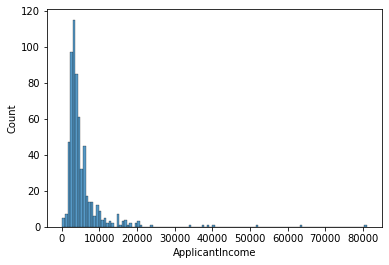

In [10]:
sns.histplot(data=df_train, x="ApplicantIncome");

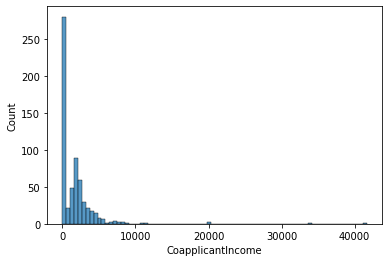

In [11]:
sns.histplot(data=df_train, x="CoapplicantIncome");

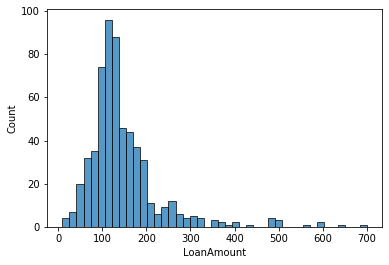

In [12]:
sns.histplot(data=df_train, x="LoanAmount");

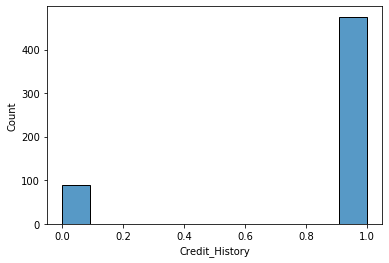

In [13]:
sns.histplot(data=df_train, x="Credit_History");

In [14]:
df_train.Credit_History.value_counts()

1.0    475
0.0     89
Name: Credit_History, dtype: int64

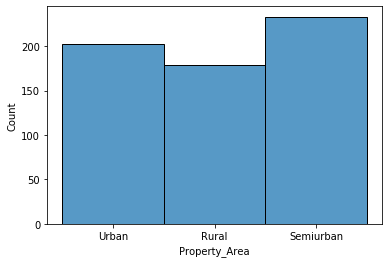

In [15]:
sns.histplot(data=df_train, x="Property_Area");

In [16]:
df_train.Property_Area.value_counts()

Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64

Dependent Variable

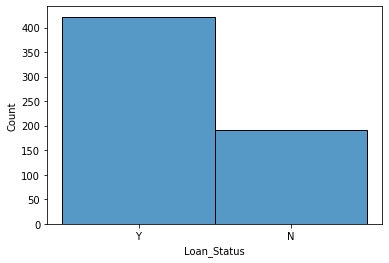

In [17]:
sns.histplot(data=df_train, x="Loan_Status");

In [18]:
df_train.Loan_Status.value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

Feature Engineering

In [19]:
df_train["TotIncome"] = df_train["ApplicantIncome"] + df_train["CoapplicantIncome"]
df_train["DebtToTotIncome"] = df_train["LoanAmount"] / df_train["TotIncome"]
df_train["DebtToIncome"] = df_train["LoanAmount"] / df_train["ApplicantIncome"]

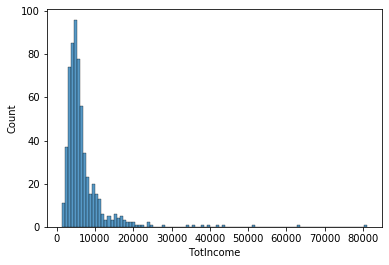

In [20]:
sns.histplot(data=df_train, x="TotIncome");

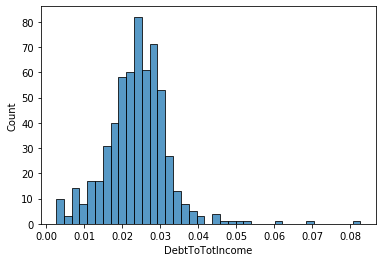

In [21]:
sns.histplot(data=df_train, x="DebtToTotIncome");

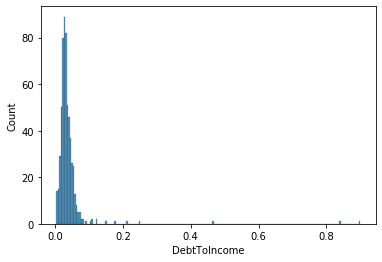

In [22]:
sns.histplot(data=df_train, x="DebtToIncome");

Given the new features I split the data where we use grouped income and not grouped

In [23]:
df_train_grouped = df_train.drop(["ApplicantIncome", "CoapplicantIncome", "DebtToIncome"], axis=1)
df_train_org = df_train.drop(["TotIncome", "DebtToTotIncome"], axis=1)

Drop irrelevant columns and split train-data into train and test-split

In [24]:
df_train_g = df_train_grouped.drop("Loan_ID", axis=1)
df_train_o = df_train_org.drop("Loan_ID", axis=1)

Missing value analysis

In [25]:
df_train_g.shape

(614, 12)

In [26]:
df_train_g.isna().sum()

Gender              13
Married              3
Dependents          15
Education            0
Self_Employed       32
LoanAmount          22
Loan_Amount_Term    14
Credit_History      50
Property_Area        0
Loan_Status          0
TotIncome            0
DebtToTotIncome     22
dtype: int64

Given few train-observations we will impute values in the preprocessing-stage

Lets start with mdoelling the original/individual data

In [27]:
X = df_train_o.drop("Loan_Status", axis=1)
y = df_train_o["Loan_Status"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Checking distribution of dependent variable in the different samples

In [28]:
y.value_counts(normalize=True)

Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64

In [29]:
y_train.value_counts(normalize=True)

Y    0.696538
N    0.303462
Name: Loan_Status, dtype: float64

In [30]:
y_test.value_counts(normalize=True)

Y    0.650407
N    0.349593
Name: Loan_Status, dtype: float64

Preprocessing and create benchmark-model using Logistic Regression

In [31]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
DebtToIncome         592 non-null float64
dtypes: float64(5), int64(1), object(6)
memory usage: 57.7+ KB


In [32]:
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [33]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
    ])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',  OneHotEncoder())
    ])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

model = Pipeline(steps = [('preprocessor', preprocessor),
                    ('classifier',LogisticRegression())
                  ])

model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

In [34]:
y_test_proba = y_test.replace(to_replace=["Y", "N"], value=[1,0])

The ROC-score is 0.75494.


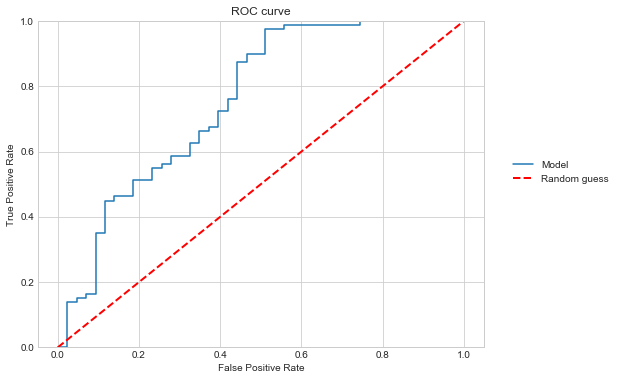

In [35]:
score = roc_auc_score(y_test_proba, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test_proba, y_pred_proba)

print(f"The ROC-score is {np.round(score,5)}.")

plt.style.use('seaborn-whitegrid')

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.ylim([0,1])
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(bbox_to_anchor = (1.3, 0.6))
plt.show()

Same modelling with the grouped variables

In [36]:
X = df_train_g.drop("Loan_Status", axis=1)
y = df_train_g["Loan_Status"]

In [37]:
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

model = Pipeline(steps = [('preprocessor', preprocessor),
                    ('classifier',LogisticRegression())
                  ])

model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

The ROC-score for the 'grouped'-model is 0.76337.
The ROC-score for the 'org'-model is 0.75494.


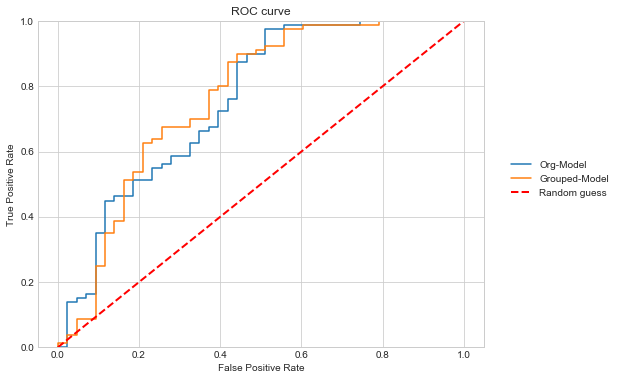

In [39]:
score_g = roc_auc_score(y_test_proba, y_pred_proba)
fpr_g, tpr_g, thresholds_g = roc_curve(y_test_proba, y_pred_proba)

print(f"The ROC-score for the 'grouped'-model is {np.round(score_g,5)}.")
print(f"The ROC-score for the 'org'-model is {np.round(score,5)}.")

plt.style.use('seaborn-whitegrid')

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Org-Model')
plt.plot(fpr_g, tpr_g, label='Grouped-Model')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.ylim([0,1])
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(bbox_to_anchor = (1.3, 0.6))
plt.show()

The grouped model is thus slightly better than the original looking at the test-sample.